# Determine GPU

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 20 11:41:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Check Memory

In [0]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


# Import Libraries

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
from scipy.sparse.linalg import svds
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Change current working directory to project folder

In [0]:
import os
os.chdir('/content/drive/My Drive/Solar Case Study')

# Read and explore the given dataset

In [0]:
#Import the data set
df = pd.read_csv('/content/drive/My Drive/Solar Case Study/output/fillna.csv', sep=',')
df.head()

,Time,Work Mode,Vpv1(V),Vpv2(V),Ipv1(A),Ipv2(A),Vac1(V),Iac1(A),Fac1(Hz),Temperature(℃),HTotal(Hrs),PV Generation(kWh),Pmeter(W),Pbackup(W),Vbackup(V),Ibackup(A),Vbat(V),Ibat(A),SOC(%),SOH(%),BMS Temperature(℃),BMS_Charge_I_Max(A),BMS_Discharge_I_Max(A),Daily Output(kWh),Total Output(kWh)
0,09/30/2018 18:01:04,Normal,129.0,0,0.0,0,238.8,0.1,49.83,30.5,1106,296.9,378,603.0,238.8,2.6,53.0,-0.4,100,100.0,24.5,2.0,50.0,1.4,552.9
1,09/30/2018 18:02:14,Normal,122.3,0,0.0,0,239.7,0.3,49.84,30.5,1106,296.9,368,605.0,239.7,2.6,52.9,1.2,99,100.0,24.5,2.0,50.0,1.4,552.9
2,09/30/2018 18:03:34,Normal,109.7,0,0.0,0,240.3,0.2,50.01,30.4,1106,296.9,370,618.0,240.3,2.7,52.8,1.2,99,100.0,24.5,2.0,50.0,1.4,552.9
3,09/30/2018 18:04:40,Normal,120.6,0,0.0,0,239.8,0.3,50.01,30.4,1106,296.9,370,597.0,239.8,2.6,52.7,1.2,99,100.0,24.5,2.0,50.0,1.4,552.9
4,09/30/2018 18:05:47,Normal,127.4,0,0.0,0,238.0,0.2,49.94,30.4,1106,296.9,367,608.0,238.0,2.6,52.6,1.2,99,100.0,24.5,10.0,50.0,1.4,552.9


In [0]:
df.drop(['Time'],axis=1,inplace=True)
df.drop(['Work Mode'],axis=1,inplace=True)
df.drop(['Vpv2(V)'],axis=1,inplace=True)
df.drop(['Ipv2(A)'],axis=1,inplace=True)
df.head()

,Vpv1(V),Ipv1(A),Vac1(V),Iac1(A),Fac1(Hz),Temperature(℃),HTotal(Hrs),PV Generation(kWh),Pmeter(W),Pbackup(W),Vbackup(V),Ibackup(A),Vbat(V),Ibat(A),SOC(%),SOH(%),BMS Temperature(℃),BMS_Charge_I_Max(A),BMS_Discharge_I_Max(A),Daily Output(kWh),Total Output(kWh)
0,129.0,0.0,238.8,0.1,49.83,30.5,1106,296.9,378,603.0,238.8,2.6,53.0,-0.4,100,100.0,24.5,2.0,50.0,1.4,552.9
1,122.3,0.0,239.7,0.3,49.84,30.5,1106,296.9,368,605.0,239.7,2.6,52.9,1.2,99,100.0,24.5,2.0,50.0,1.4,552.9
2,109.7,0.0,240.3,0.2,50.01,30.4,1106,296.9,370,618.0,240.3,2.7,52.8,1.2,99,100.0,24.5,2.0,50.0,1.4,552.9
3,120.6,0.0,239.8,0.3,50.01,30.4,1106,296.9,370,597.0,239.8,2.6,52.7,1.2,99,100.0,24.5,2.0,50.0,1.4,552.9
4,127.4,0.0,238.0,0.2,49.94,30.4,1106,296.9,367,608.0,238.0,2.6,52.6,1.2,99,100.0,24.5,10.0,50.0,1.4,552.9


In [0]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  632948
No of columns:  21


In [0]:
#Check Data types
df.dtypes

Vpv1(V)                   float64
Ipv1(A)                   float64
Vac1(V)                   float64
Iac1(A)                   float64
Fac1(Hz)                  float64
Temperature(℃)            float64
HTotal(Hrs)                 int64
PV Generation(kWh)        float64
Pmeter(W)                   int64
Pbackup(W)                float64
Vbackup(V)                float64
Ibackup(A)                float64
Vbat(V)                   float64
Ibat(A)                   float64
SOC(%)                      int64
SOH(%)                    float64
BMS Temperature(℃)        float64
BMS_Charge_I_Max(A)       float64
BMS_Discharge_I_Max(A)    float64
Daily Output(kWh)         float64
Total Output(kWh)          object
dtype: object

In [0]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 Vpv1(V)                     0
Ipv1(A)                     0
Vac1(V)                     0
Iac1(A)                     0
Fac1(Hz)                    0
Temperature(℃)              0
HTotal(Hrs)                 0
PV Generation(kWh)          0
Pmeter(W)                   0
Pbackup(W)                171
Vbackup(V)                  0
Ibackup(A)                  0
Vbat(V)                     0
Ibat(A)                     0
SOC(%)                      0
SOH(%)                    171
BMS Temperature(℃)        171
BMS_Charge_I_Max(A)       171
BMS_Discharge_I_Max(A)    171
Daily Output(kWh)           0
Total Output(kWh)           0
dtype: int64


In [0]:
# Computes various summary statistics, excluding NaN values 
df.describe() 

,Vpv1(V),Ipv1(A),Vac1(V),Iac1(A),Fac1(Hz),Temperature(℃),HTotal(Hrs),PV Generation(kWh),Pmeter(W),Pbackup(W),Vbackup(V),Ibackup(A),Vbat(V),Ibat(A),SOC(%),SOH(%),BMS Temperature(℃),BMS_Charge_I_Max(A),BMS_Discharge_I_Max(A),Daily Output(kWh)
count,632948.000000,632948.000000,632948.000000,632948.000000,632948.000000,632948.000000,632948.000000,632948.000000,632948.000000,632777.000000,632948.000000,632948.000000,632948.000000,632948.000000,632948.000000,632777.000000,632777.000000,632777.000000,632777.000000,632948.000000
mean,221.237459,1.937078,233.913954,3.351879,49.224997,33.036854,7805.478924,4334.789063,-369.591548,896.794305,237.448661,4.087456,52.752619,-0.721976,97.712641,99.838648,25.084856,5.305303,52.457935,9.769470
std,198.226915,2.889007,29.381302,4.567633,6.154759,5.902859,3546.811933,2335.590326,1646.042355,310.197773,3.010459,1.446386,2.305028,3.958576,12.190872,4.013629,3.486101,10.216431,13.178528,8.817119
min,0.000000,0.000000,0.000000,0.000000,0.000000,16.600000,1106.000000,296.900000,-13124.000000,0.000000,200.700000,0.300000,0.000000,-44.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,235.600000,0.200000,49.910000,28.900000,4730.000000,2470.800000,-837.000000,701.000000,235.600000,3.100000,52.900000,-0.900000,100.000000,100.000000,22.500000,2.000000,50.000000,0.200000
50%,361.600000,0.000000,237.600000,0.300000,49.990000,32.300000,8091.000000,4087.500000,-478.000000,862.000000,237.600000,3.900000,53.000000,-0.600000,100.000000,100.000000,26.000000,2.000000,50.000000,8.600000
75%,407.500000,3.500000,239.600000,6.000000,50.070000,36.500000,10705.000000,6297.300000,450.000000,1041.000000,239.600000,4.800000,53.100000,-0.200000,100.000000,100.000000,27.500000,2.000000,50.000000,18.400000
max,544.200000,12.800000,252.600000,21.800000,50.550000,57.700000,13915.000000,8555.300000,7968.000000,5994.000000,252.600000,25.900000,58.400000,69.100000,100.000000,100.000000,37.300000,100.000000,100.000000,28.800000


In [0]:
# Computing correlations 
df.corr() 

,Vpv1(V),Ipv1(A),Vac1(V),Iac1(A),Fac1(Hz),Temperature(℃),HTotal(Hrs),PV Generation(kWh),Pmeter(W),Pbackup(W),Vbackup(V),Ibackup(A),Vbat(V),Ibat(A),SOC(%),SOH(%),BMS Temperature(℃),BMS_Charge_I_Max(A),BMS_Discharge_I_Max(A),Daily Output(kWh)
Vpv1(V),1.000000,0.606339,-0.063009,0.611784,-0.035421,0.410499,0.000536,0.006171,0.431786,0.326846,-0.285210,0.278282,0.043054,-0.026608,0.056522,0.009577,-0.002863,-0.103811,0.017570,0.037364
Ipv1(A),0.606339,1.000000,0.057818,0.985556,0.055716,0.578141,-0.012992,-0.013520,0.702703,0.173821,0.038341,0.132336,0.035996,-0.082585,0.052701,0.002063,-0.015820,-0.073239,0.007823,0.018499
Vac1(V),-0.063009,0.057818,1.000000,0.093230,0.995359,-0.053390,-0.076022,-0.087593,0.000669,-0.003678,0.411716,-0.011442,0.092960,-0.204522,0.057933,-0.005043,-0.085979,-0.215096,-0.045594,0.010094
Iac1(A),0.611784,0.985556,0.093230,1.000000,0.091451,0.570044,-0.017467,-0.018824,0.699503,0.180139,0.048270,0.136817,0.028018,0.026162,0.042275,0.002946,-0.027393,-0.058832,0.004994,0.017590
Fac1(Hz),-0.035421,0.055716,0.995359,0.091451,1.000000,-0.031802,-0.076877,-0.086467,-0.028273,0.036967,0.323492,0.031085,0.094081,-0.212349,0.060632,-0.004911,-0.069794,-0.217336,-0.039647,0.036847
Temperature(℃),0.410499,0.578141,-0.053390,0.570044,-0.031802,1.000000,-0.038706,0.006264,0.413786,0.272673,-0.224294,0.282586,-0.010438,-0.078290,-0.011080,0.007312,0.589969,-0.008749,-0.032258,0.388043
HTotal(Hrs),0.000536,-0.012992,-0.076022,-0.017467,-0.076877,-0.038706,1.000000,0.994423,-0.014487,-0.045805,-0.020452,-0.036685,0.149433,-0.014038,0.253737,0.069185,-0.020246,-0.054970,0.447965,-0.017957
PV Generation(kWh),0.006171,-0.013520,-0.087593,-0.018824,-0.086467,0.006264,0.994423,1.000000,-0.014294,-0.039103,-0.043208,-0.027313,0.141812,-0.019205,0.241924,0.067449,0.057814,-0.033080,0.473780,-0.020423
Pmeter(W),0.431786,0.702703,0.000669,0.699503,-0.028273,0.413786,-0.014487,-0.014294,1.000000,-0.042080,0.270152,-0.070379,0.013813,-0.002430,0.037959,-0.001704,0.001140,-0.065464,-0.033817,0.035185
Pbackup(W),0.326846,0.173821,-0.003678,0.180139,0.036967,0.272673,-0.045805,-0.039103,-0.042080,1.000000,-0.383361,0.983093,0.032756,-0.001432,0.050466,0.013226,0.058022,-0.066687,0.068294,0.289086


In [0]:
# computes numerical data ranks 
df.rank() 

,Vpv1(V),Ipv1(A),Vac1(V),Iac1(A),Fac1(Hz),Temperature(℃),HTotal(Hrs),PV Generation(kWh),Pmeter(W),Pbackup(W),Vbackup(V),Ibackup(A),Vbat(V),Ibat(A),SOC(%),SOH(%),BMS Temperature(℃),BMS_Charge_I_Max(A),BMS_Discharge_I_Max(A),Daily Output(kWh),Total Output(kWh)
0,290206.5,164488.0,411491.0,75753.0,45230.5,227429.0,12.5,94.0,469915.5,74260.0,411491.0,71686.0,272466.5,372331.0,366739.0,316899.5,244934.5,282951.0,300965.5,212091.0,308026.5
1,288572.5,164488.0,482453.5,283680.5,55966.0,227429.0,12.5,94.0,469224.0,75365.0,482454.5,71686.0,139171.5,592741.5,66312.5,316899.5,244934.5,282951.0,300965.5,212091.0,308026.5
2,286240.5,164488.0,524184.0,193512.0,355275.0,223057.5,12.5,94.0,469360.5,82659.0,524184.0,80810.5,101442.0,592741.5,66312.5,316899.5,244934.5,282951.0,300965.5,212091.0,308026.5
3,288191.0,164488.0,489609.0,283680.5,355275.0,223057.5,12.5,94.0,469360.5,70927.5,489610.0,71686.0,70858.0,592741.5,66312.5,316899.5,244934.5,282951.0,300965.5,212091.0,308026.5
4,289952.0,164488.0,345695.0,193512.0,204308.0,223057.5,12.5,94.0,469155.5,77017.5,345695.0,71686.0,57398.0,592741.5,66312.5,316899.5,244934.5,553213.0,300965.5,212091.0,308026.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632943,325512.0,164488.0,10423.0,283680.5,28366.0,213346.0,632945.0,632883.0,19551.0,549917.0,705.5,519619.0,272466.5,42788.0,366739.0,316899.5,223351.5,590927.0,613596.5,512079.5,35175.5
632944,316100.0,164488.0,10452.5,193512.0,35187.0,208781.5,632945.0,632883.0,18710.5,539839.5,747.0,519619.0,481265.5,294430.0,366739.0,316899.5,223351.5,590927.0,613596.5,512079.5,35175.5
632945,331435.5,164488.0,10359.5,193512.0,35187.0,208781.5,632945.0,632883.0,24707.5,535185.5,625.5,519619.0,272466.5,478222.0,366739.0,316899.5,223351.5,590927.0,613596.5,512079.5,35175.5
632946,332795.0,164488.0,10143.0,283680.5,23598.5,208781.5,632945.0,632883.0,17931.5,555203.0,406.0,538570.0,272466.5,294430.0,366739.0,316899.5,223351.5,590927.0,613596.5,512079.5,35175.5


In [0]:
df.fillna(df.mean())

In [0]:
print('Number of missing values across columns-\n', df.isnull().sum())

In [0]:
df.to_csv(r'/content/drive/My Drive/Solar Case Study/output/dropped.csv', index = False, header=True)

In [0]:
# plot a histogram  
df['Total Output(kWh)'].hist(bins=10) 
  
# shows presence of a lot of outliers/extreme values 
df.boxplot(column='Total Output(kWh)', by = 'Time') 
  
# plotting points as a scatter plot 
x = df["Total Output(kWh)"] 
y = df["Time"] 
plt.scatter(x, y, label= "stars", color= "m",  
            marker= "*", s=30) 
# x-axis label 
plt.xlabel('Total Output(kWh)') 
# frequency label 
plt.ylabel('Time') 
# function to show the plot 
plt.show() 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f531ac44f60>,
      dtype=object)

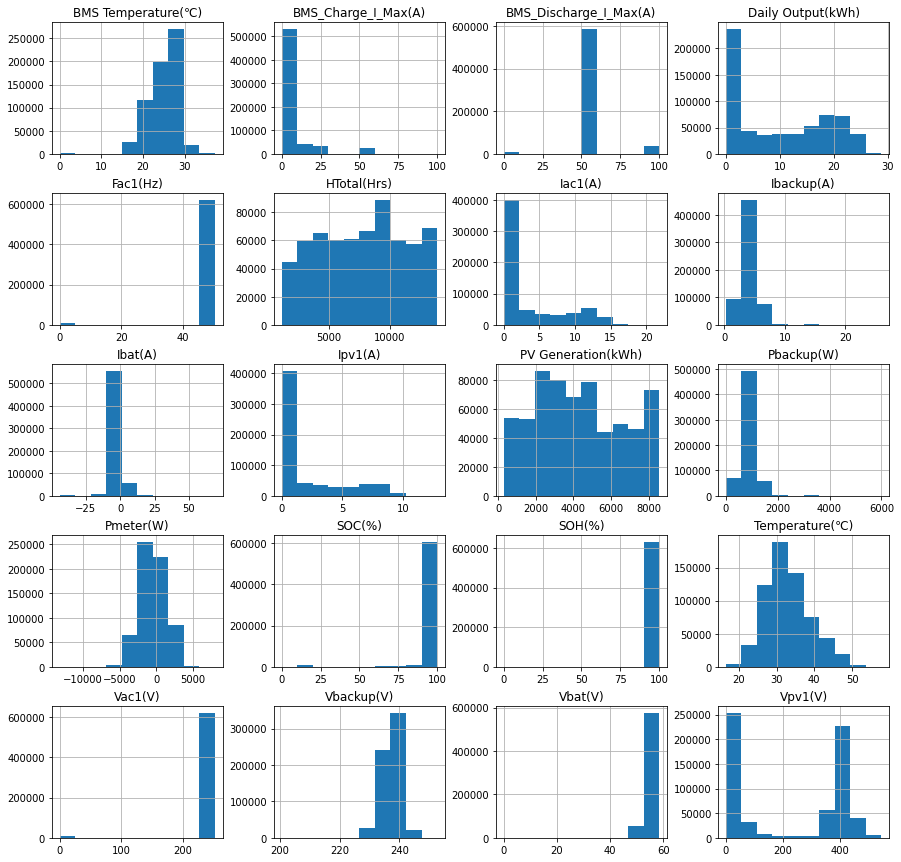

In [0]:
df.hist(figsize = (15,15))

In [0]:
for n in df.columns[:-1]:
    median = df[n].median()
    df[n] = df[n].fillna(median)

In [0]:
df.isnull().sum()

Vpv1(V)                   0
Ipv1(A)                   0
Vac1(V)                   0
Iac1(A)                   0
Fac1(Hz)                  0
Temperature(℃)            0
HTotal(Hrs)               0
PV Generation(kWh)        0
Pmeter(W)                 0
Pbackup(W)                0
Vbackup(V)                0
Ibackup(A)                0
Vbat(V)                   0
Ibat(A)                   0
SOC(%)                    0
SOH(%)                    0
BMS Temperature(℃)        0
BMS_Charge_I_Max(A)       0
BMS_Discharge_I_Max(A)    0
Daily Output(kWh)         0
Total Output(kWh)         0
dtype: int64

In [0]:
for col_name in df.columns[:-1]:
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    
    lower = q1 - 1.5 * iqr
    higher = q3 + 1.5 * iqr
    
    df.loc[(df[col_name] < lower) | (df[col_name] > higher), col_name] = df[col_name].median()

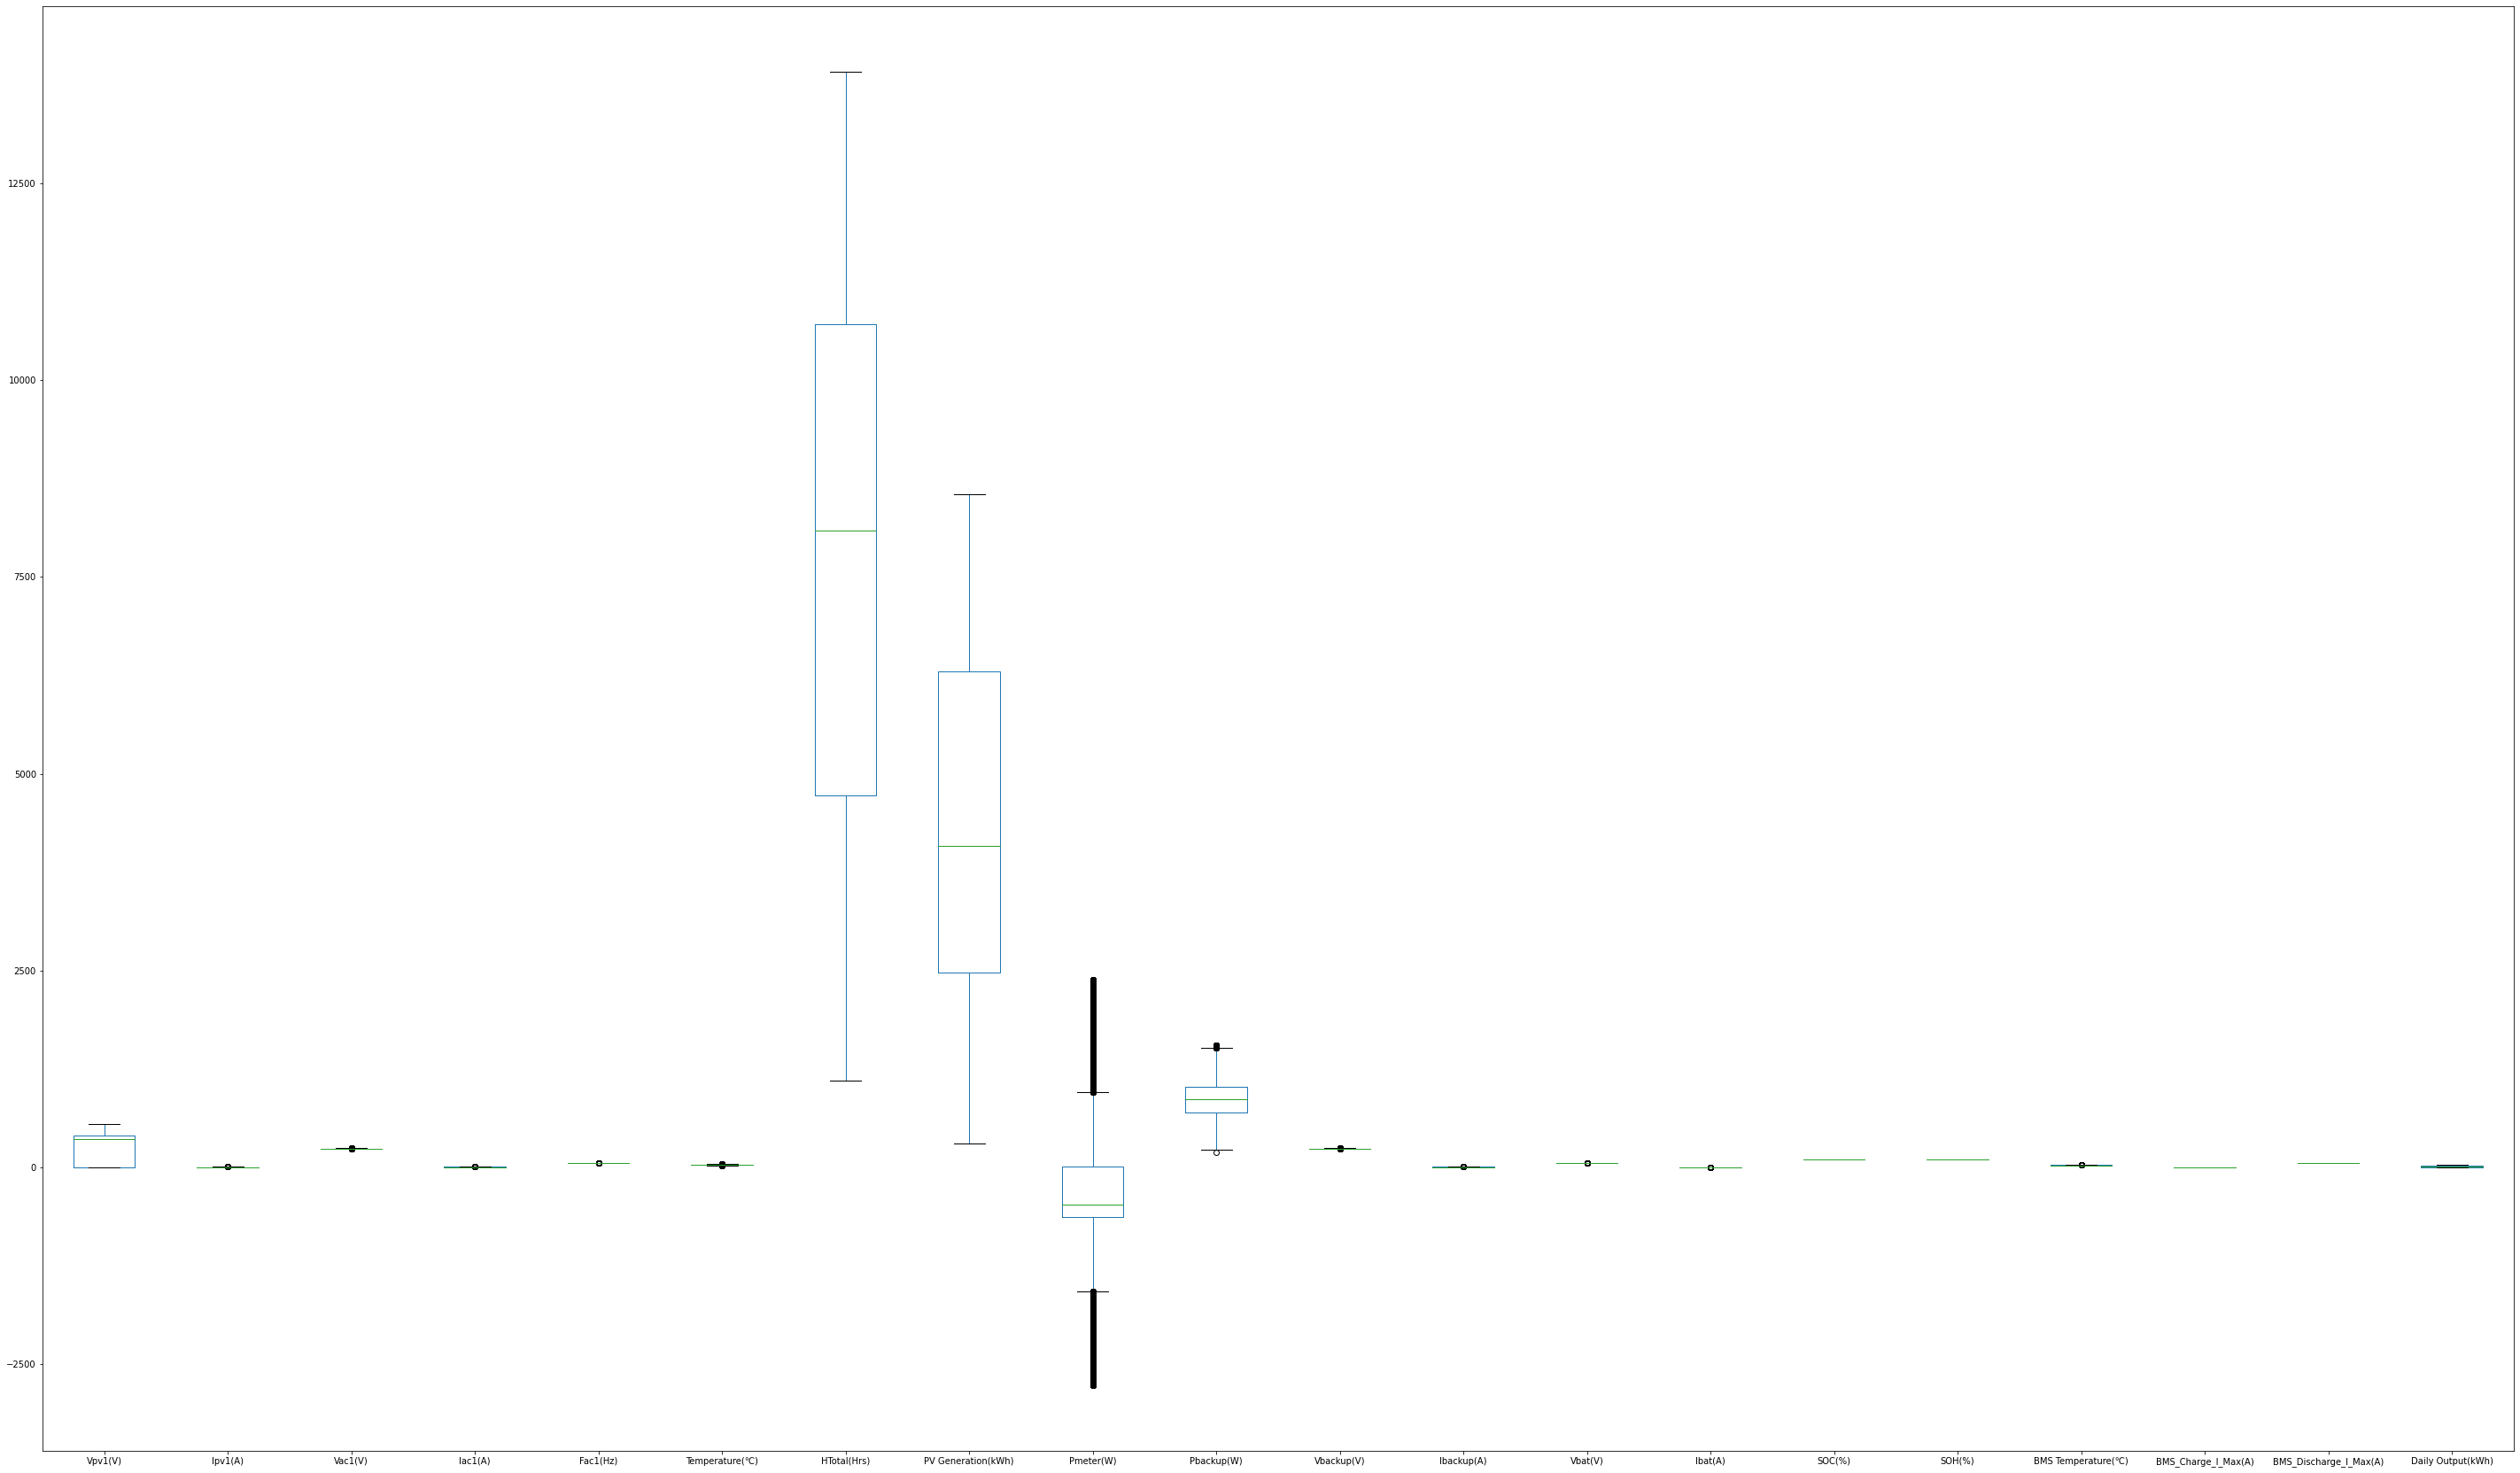

In [0]:
df.plot(kind = 'box', figsize = (50,30))

In [0]:
sns_plot = sns.pairplot(df, diag_kind = 'kde')
sns_plot.savefig('output.png')

Output hidden; open in https://colab.research.google.com to view.